# Applying Machine Learning Models

In [119]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [120]:
data1 = pd.read_csv('Data_UCI_not_noise_1.csv')
data2 = pd.read_csv('Data_UCI_not_noise_2.csv')

df_concat = pd.concat([data1, data2])

print(df_concat.shape)

(9233, 642)


In [121]:
features_act = list()
features_uid = list()

with open('act_feature_importance.txt', 'r') as f:
    features_act = f.read().splitlines()

with open('uid_feature_importance.txt', 'r') as f:
    features_uid = f.read().splitlines()

# print(features_act)
# print(features_uid)

In [122]:
from sklearn.model_selection import train_test_split

def split_train_test_data(df, id):
  X = df.drop(['user_Id', 'activity_Id'], axis=1)
  y = df[id]

  return train_test_split(X, y, test_size=0.33, random_state=42) # X_train, X_test, y_train, y_test

  # for i in X_train.columns:
  #   print(X_train[i].dtype)
  # print(X_train.dtypes)

  # # 訓練用
  # X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_train = train['subject']

  # # テスト用
  # X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_test = test['subject']

  # print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
  # print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

Let's make a function to plot the confusion matrix

In [123]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [124]:
# 任意のモデルを実行
def perform_model_epsilon(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(15, 15))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    # print('****************| Classifiction Report |****************')
    # classification_report = metrics.classification_report(y_test, y_pred)
    
    # # store report in results
    # results['classification_report'] = classification_report
    # print(classification_report)
    
    # get f1 score
    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    print("\n F1 Score:{}".format(f1))
    
    # add the trained model to the results
    results['model'] = model
    
    return results, f1
    

Make function to print the gridsearch Parameters

In [125]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

In [126]:
labels_act = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

labels_uid = list()
for i in range(1, 31):
    labels_uid.append(i)

In [127]:
n = 119
# f_add_weighted_noise = set()
# for f in features_uid[:n]:
#   f_add_weighted_noise.add(f)
# print(f_add_weighted_noise)

# n = 211
f_add_weighted_noise = set()
for f in features_uid[:n]:
  # 重複していないものを入れる
  if f not in features_act[:n]:
    f_add_weighted_noise.add(f)
print(len(f_add_weighted_noise))

83


In [128]:
weighted_epsilon_array = [0.001, 0.005, 0.008, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1]
weighted_epsilon = weighted_epsilon_array[0]

## 2. Random Forest Classifier

## UID

--------
epsilon:  1.1
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:05:30.871108

Predicting test data
==> testing time:- 0:00:00.103762

==> Accuracy:- 0.05480800787659994


 ********Confusion Matrix********

 [[ 3  0  0  0  0  0  0  0  0  0  0  0  1  1  0  1  2  4  0  0 20  0  1 20
  20 27  5  0  7  8]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  2  0  0  3  2  4  0  0 14  0  0  8
  17 36  7  0  4  2]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  4  0  0 11  0  1 18
  22 28  2  0  2  1]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  1  0  0  9  0  0  8
  29 32  5  0  3  1]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  1  0  2  1  2  5  0  0  6  0  0 16
  19 31  3  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  3  0  0  9  0  0 15
  23 27  4  0  2  2]
 [ 1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  1  5  0  0 16  0  1  6
  13 30  6  0  1  1]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0

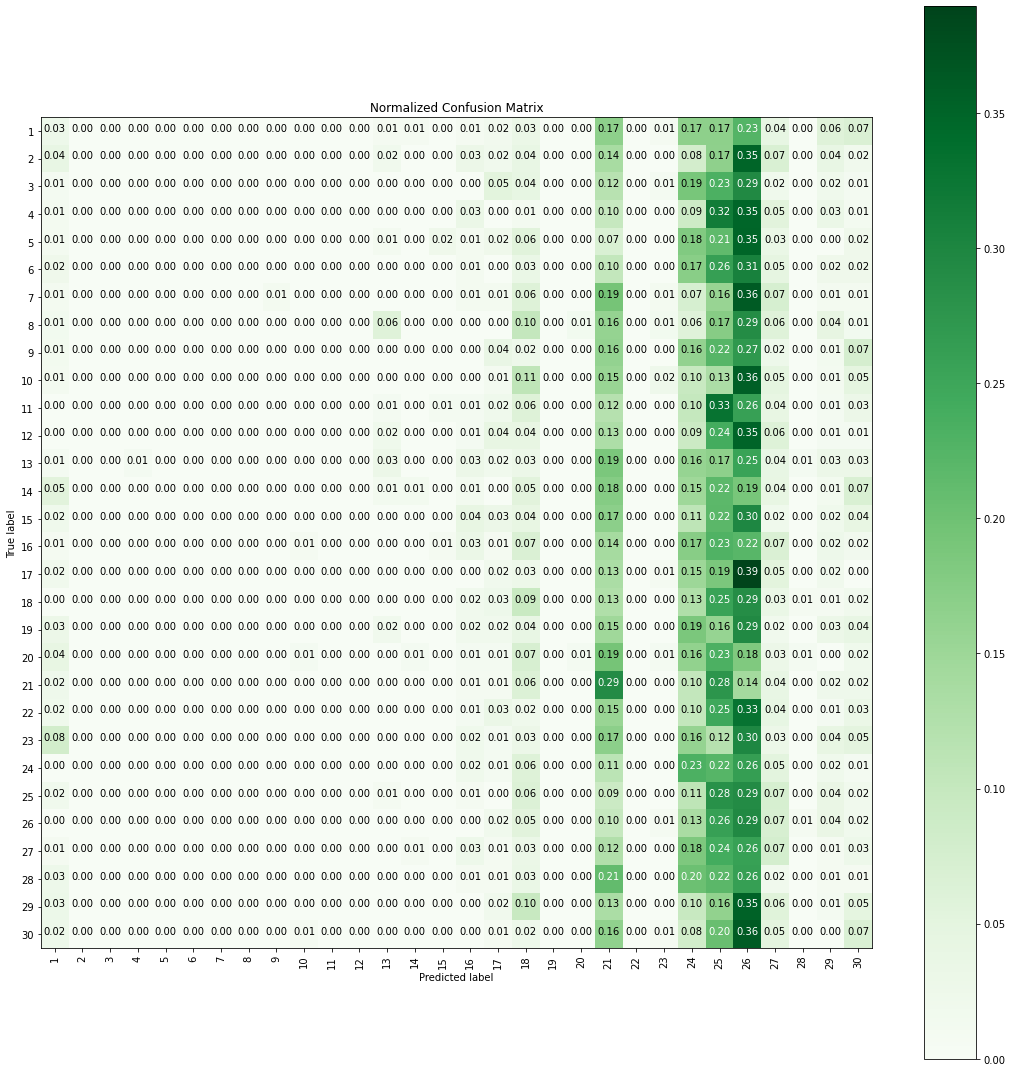


 F1 Score:0.02688222467057043


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.05544734707843642
--------
epsilon:  1.2
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:05:34.118977

Predicting test data
==> testing time:- 0:00:00.119911

==> Accuracy:- 0.05612077453232688


 ********Confusion Matrix********

 [[14  1  2  0  0  0  0  0  0  2  0  0  4  0  1  2  3 10  0  1 14  0  3 12
  12 21  7  0  5  6]
 [ 7  0  1  0  0  0  0  0  1  0  0  0  4  1  1  4  4 11  0  1 11  0  2 10
  12 17  9  0  3  4]
 [ 4  0  0  1  0  0  0  0  0  0  0  0  0  0  0  6  6  4  0  0  8  0  3 18
  17 17  2  2  4  3]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  2  0  1  2  3  4  0  0  9 

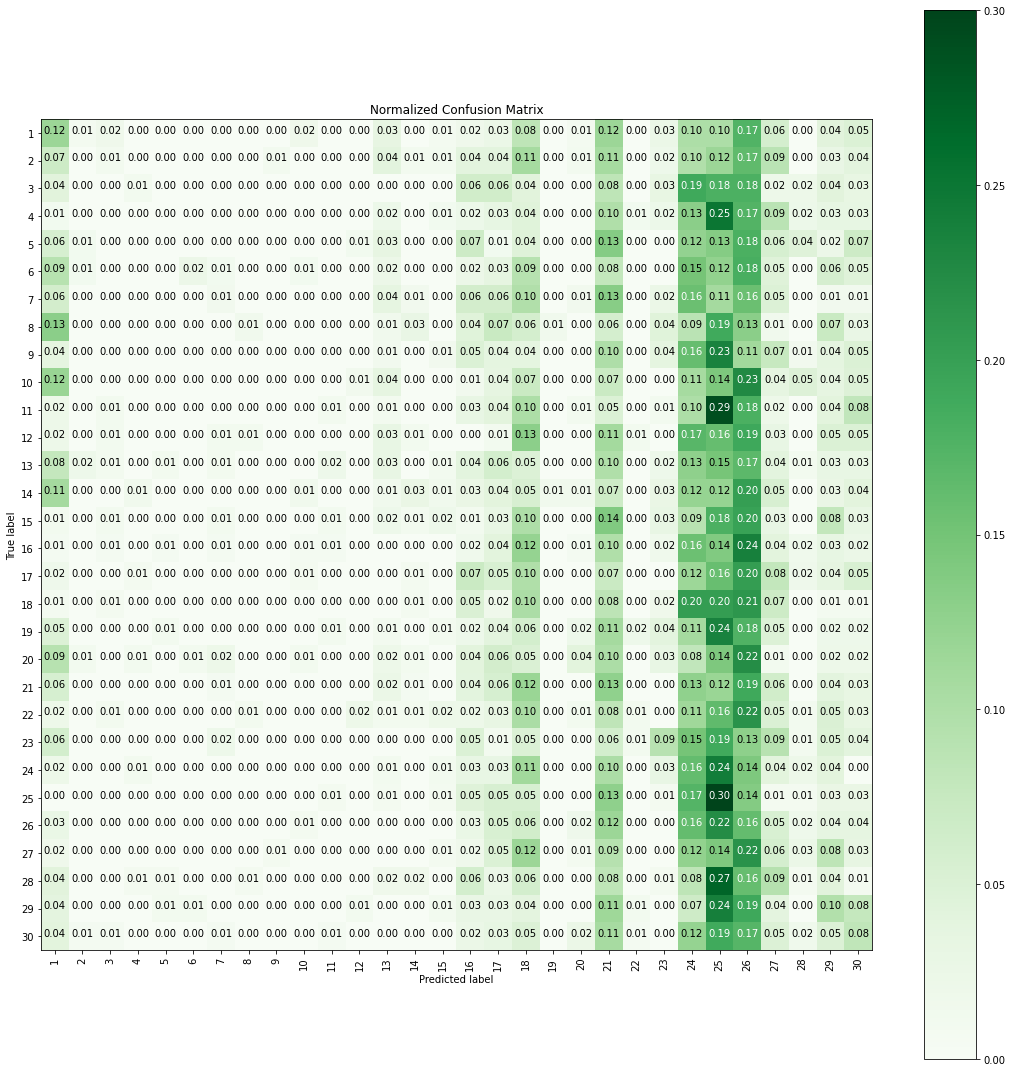


 F1 Score:0.0403490593191627


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.06256054893346376
--------
epsilon:  1.3
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:05:19.222917

Predicting test data
==> testing time:- 0:00:00.090726

==> Accuracy:- 0.05382343288480473


 ********Confusion Matrix********

 [[13  0  0  0  0  0  0  0  0  0  0  0  1  0  1  3  4  7  0  0 13  0  1 10
  24 35  4  0  3  1]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  2  3  0  0 17  0  0 14
  18 29  5  0  3  2]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  4  0  0 18  0  1 10
  20 29  3  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  4  5  0  0  8

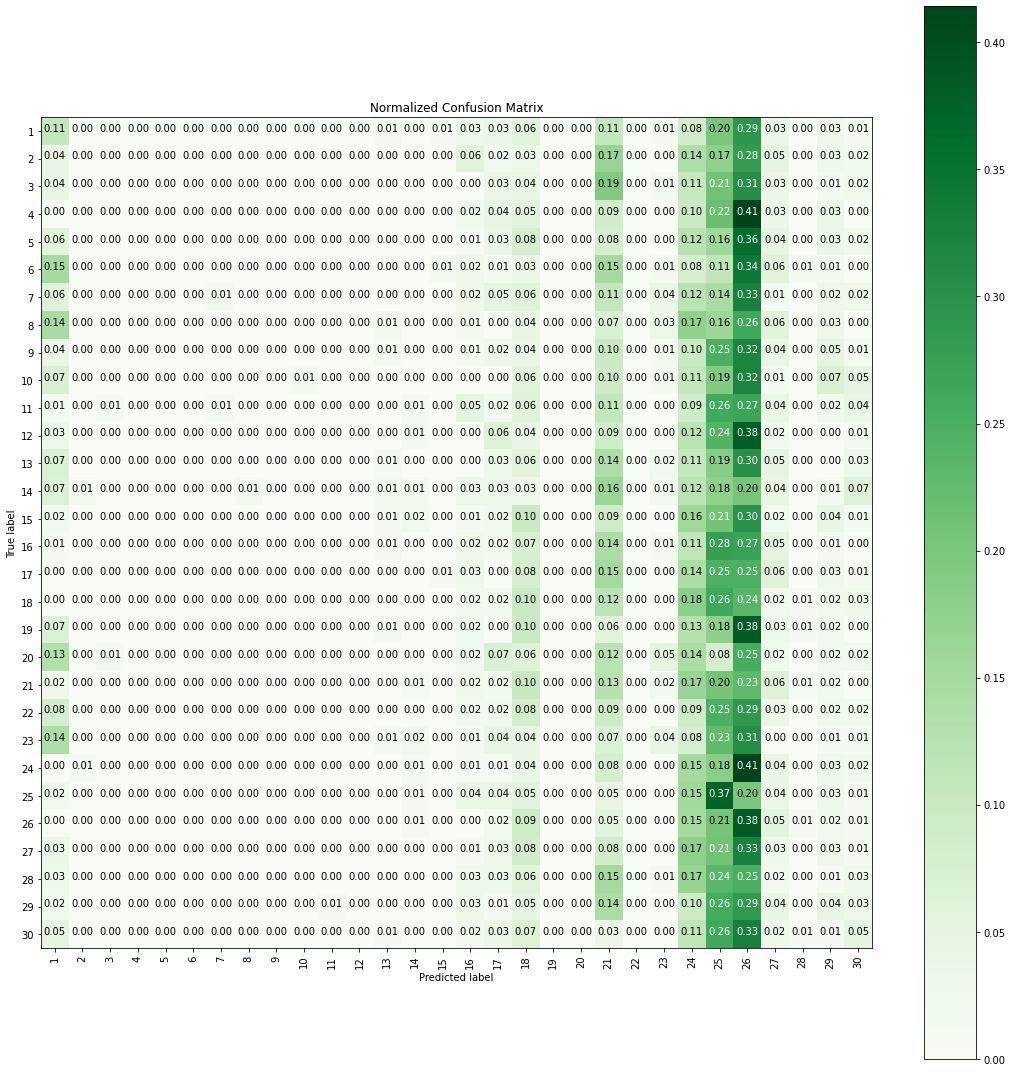


 F1 Score:0.027492357511122088


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.06563145240386939
--------
epsilon:  1.5
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:05:16.544736

Predicting test data
==> testing time:- 0:00:00.117675

==> Accuracy:- 0.07154578273711848


 ********Confusion Matrix********

 [[27  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  9  0  1  7  0  1  9
  24 26  4  0  1 10]
 [ 9  1  0  0  0  0  0  1  0  0  1  0  3  2  0  2  1 10  0  0 12  1  0 12
  18 21  2  0  5  2]
 [ 3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  8  0  0 21  0  0 15
  16 22  3  0  1  3]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  2 11  0  0 10

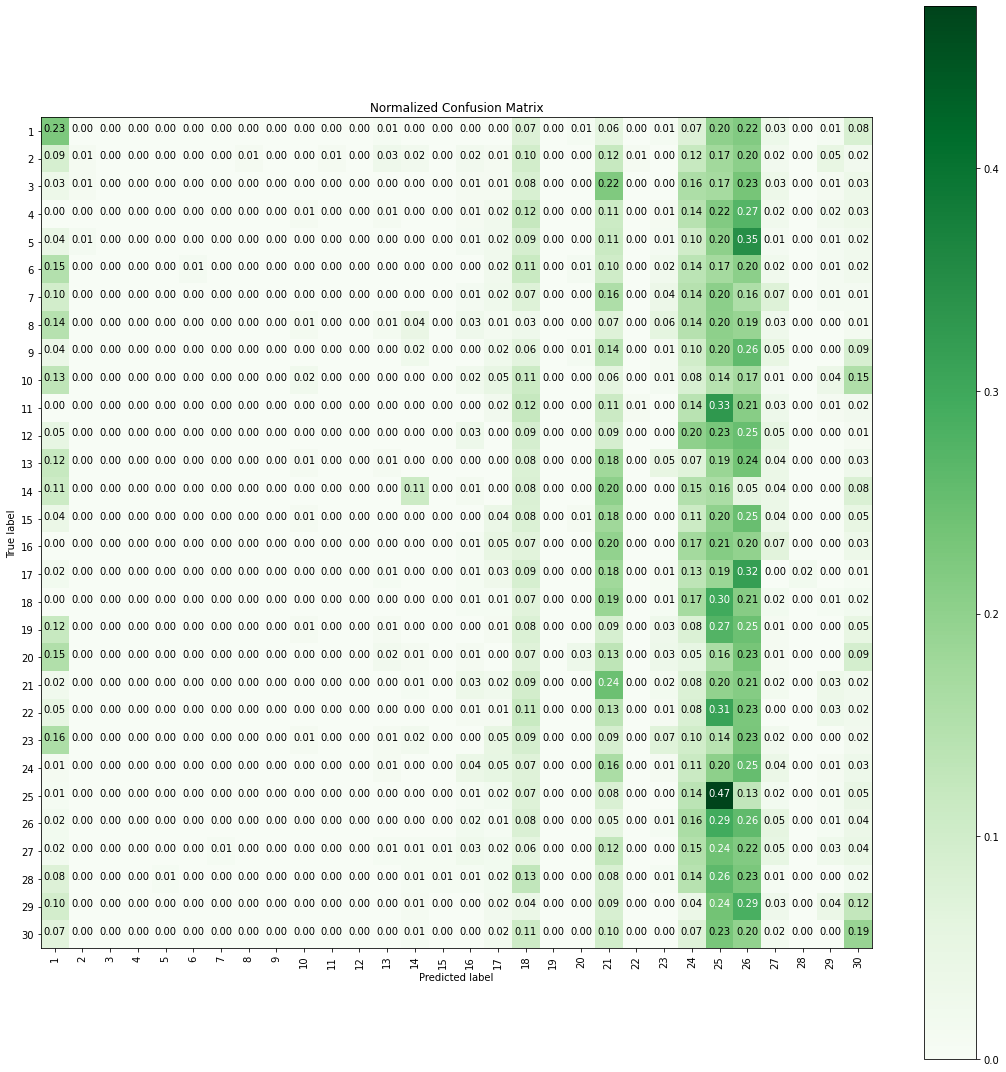


 F1 Score:0.04465487234205738


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.07694732814159014
--------
epsilon:  1.6
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:04:58.934811

Predicting test data
==> testing time:- 0:00:00.127589

==> Accuracy:- 0.08204791598293404


 ********Confusion Matrix********

 [[28  0  0  0  1  0  1  0  0  1  0  0  1  2  0  0  1  7  0  1  5  0  2 16
  14 22  5  0  3 10]
 [ 3  0  0  0  0  0  1  0  0  0  1  0  2  1  0  1  2 10  0  0 17  2  1 18
  12 17  8  1  3  3]
 [ 2  0  0  0  0  0  1  0  0  0  0  0  1  0  0  1  2  3  0  0 13  0  2 13
  29 21  0  1  5  1]
 [ 2  0  2  0  0  0  0  0  0  0  0  0  1  0  0  2  6  4  0  0  5 

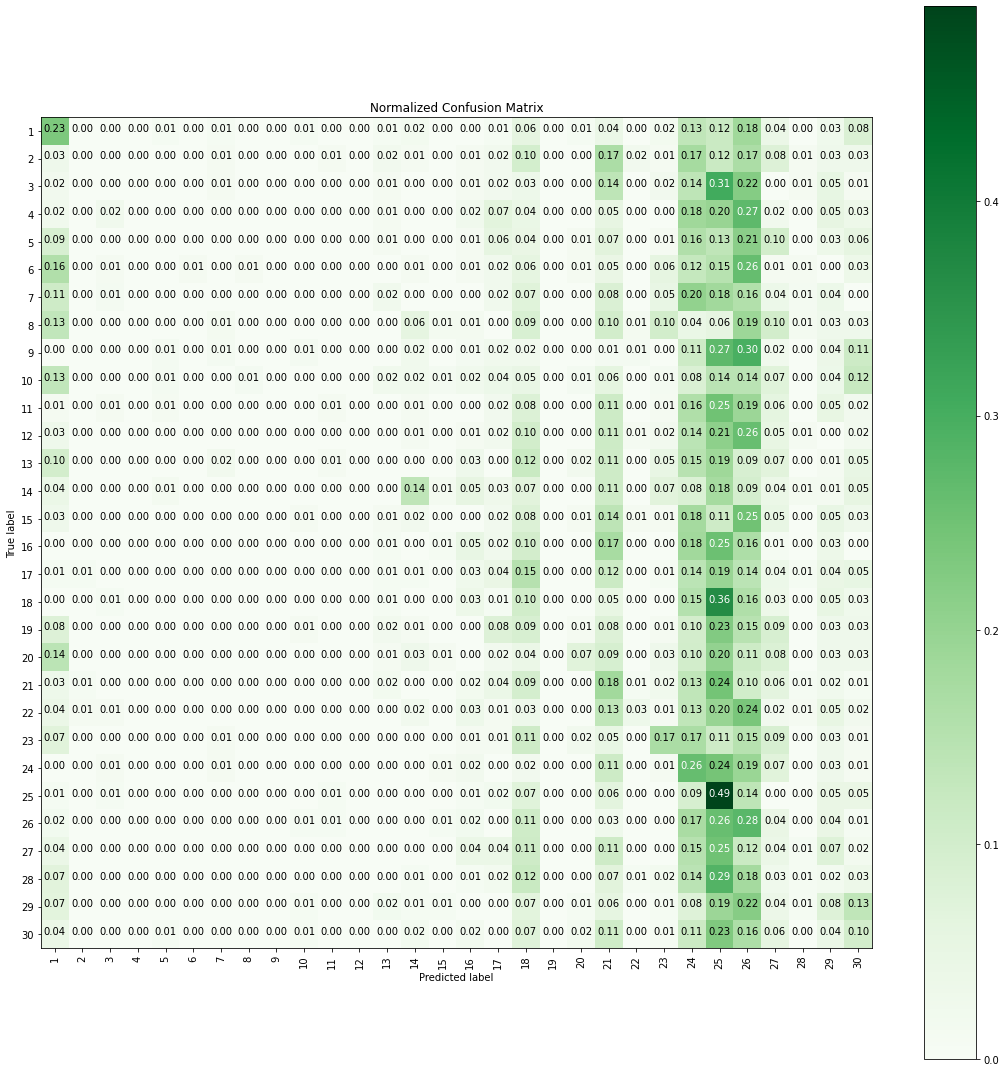


 F1 Score:0.0550249744119981


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.08260657199984851
--------
epsilon:  1.7
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:04:57.541617

Predicting test data
==> testing time:- 0:00:00.102031

==> Accuracy:- 0.09189366590088612


 ********Confusion Matrix********

 [[34  0  0  0  0  0  0  0  0  0  0  0  3  3  0  1  4  5  0  2 11  0  3 12
  18 14  3  0  2  5]
 [13  0  0  0  0  0  0  0  0  0  0  0  2  1  0  4  1  2  0  0 21  0  0 16
  10 22  5  1  4  1]
 [ 3  0  0  0  0  0  0  0  0  3  1  0  0  0  1  1  1  8  0  0 15  0  2 13
  18 22  3  0  1  3]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  8  0  0  7  

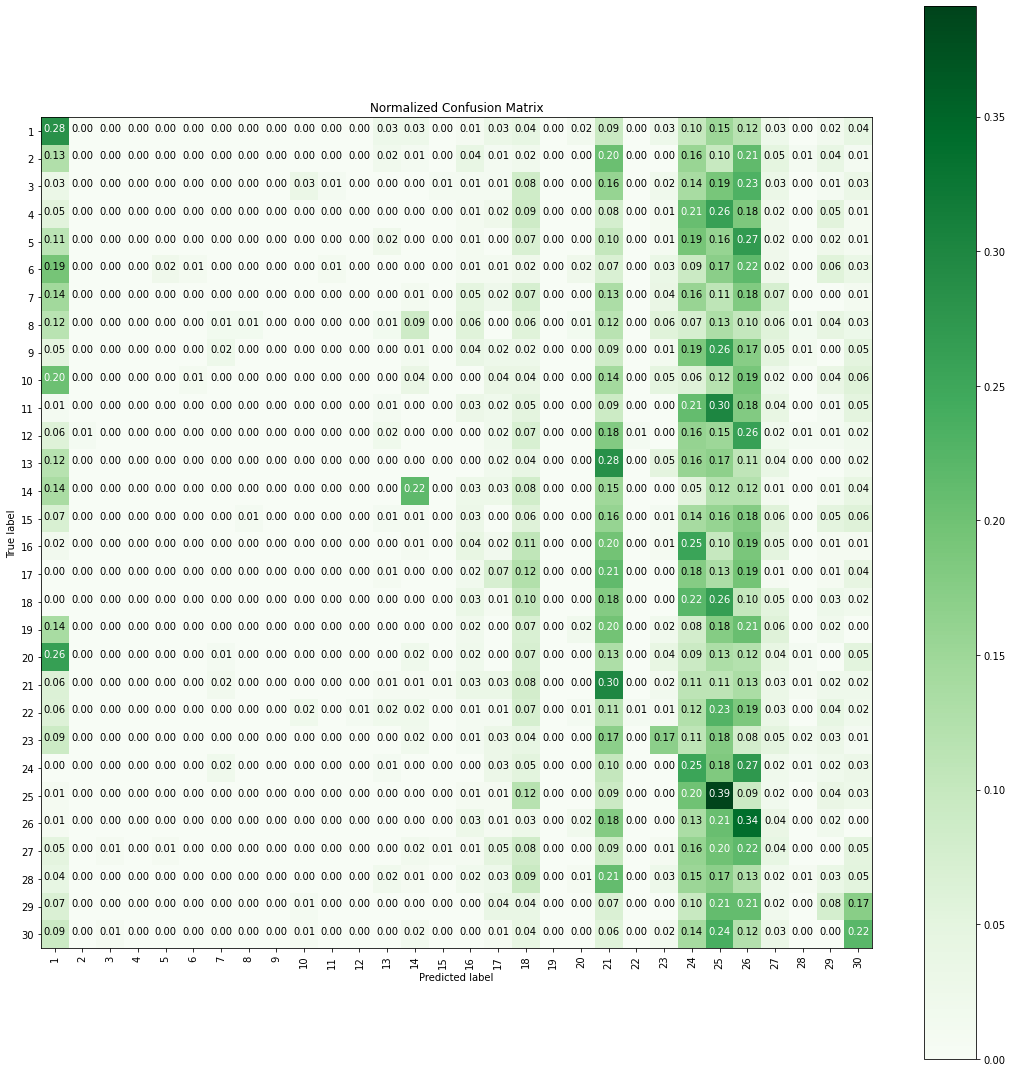


 F1 Score:0.059729753518934454


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.09020063915121138
--------
epsilon:  1.8
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:24:08.692181

Predicting test data
==> testing time:- 0:00:00.122738

==> Accuracy:- 0.0935346242205448


 ********Confusion Matrix********

 [[31  0  0  0  0  0  0  0  0  0  0  0  0  3  0  2  2  9  0  2 11  0  3  6
  19 17  4  0  5  6]
 [ 9  0  0  0  0  0  1  0  0  0  0  0  1  2  0  2  1  5  0  0 13  0  0 16
  12 29  6  0  2  4]
 [ 7  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  2  8  0  0 13  0  0 24
  14 22  0  2  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  5  3  0  0  5 

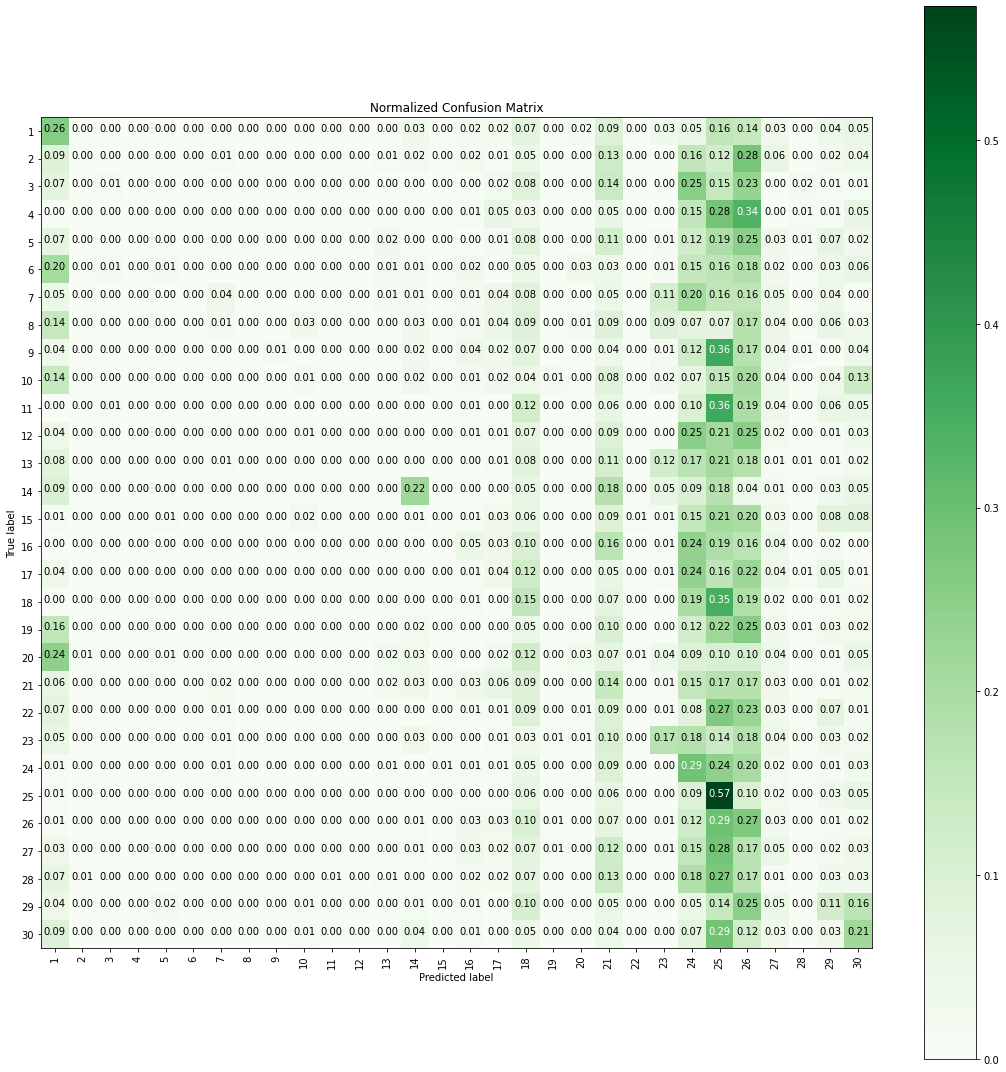


 F1 Score:0.06238958422937489


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.09068842619135617
--------
epsilon:  1.9
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:05:49.900722

Predicting test data
==> testing time:- 0:00:00.135659

==> Accuracy:- 0.09025270758122744


 ********Confusion Matrix********

 [[25  0  1  0  0  0  1  0  0  1  1  1  2  6  1  6  3  5  0  1  6  0  8  7
   9 10  7  0 11  8]
 [ 7  0  2  0  0  0  0  4  0  0  0  1  1  2  1  4  1  9  0  1 14  1  1 18
   8 17  6  0  4  1]
 [ 2  1  0  0  0  0  1  0  0  0  0  0  0  2  1  2  4  8  0  1 11  1  0 12
  18 16  5  1  4  5]
 [ 1  1  1  2  1  1  0  0  0  1  2  0  0  0  0  1  7  5  0  0  5 

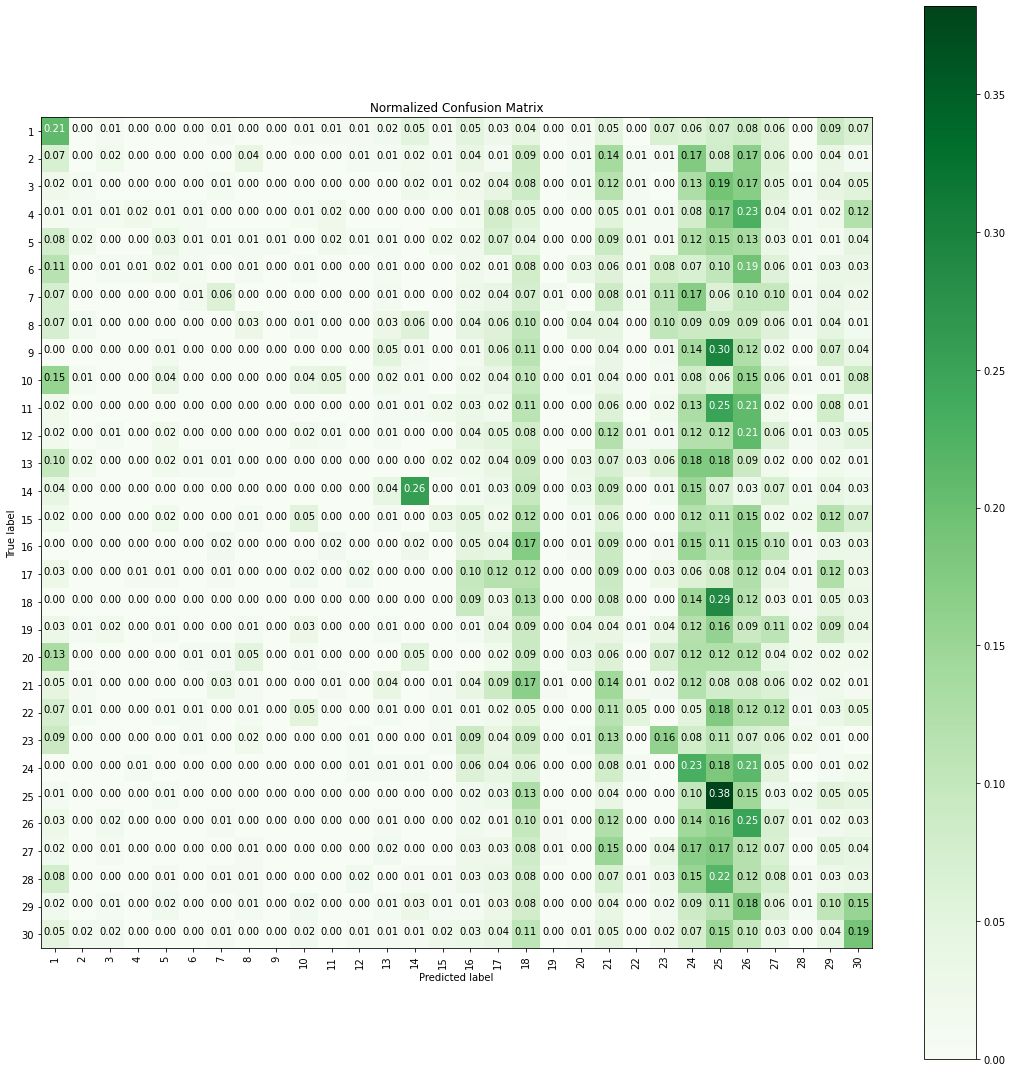


 F1 Score:0.07212880940718


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.10313581114348513
--------
epsilon:  2.0
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:05:43.799342

Predicting test data
==> testing time:- 0:00:00.083676

==> Accuracy:- 0.11782080735149328


 ********Confusion Matrix********

 [[41  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  6  7  0  1  3  0  1  8
  16 17  9  0  5  4]
 [11  0  0  0  0  0  0  0  0  0  0  1  1  0  0  2  7  4  0  1 14  0  0 15
  11 18 10  1  5  2]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  2  5  0  0  9  0  1 14
  23 22  3  0  4  3]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  3  

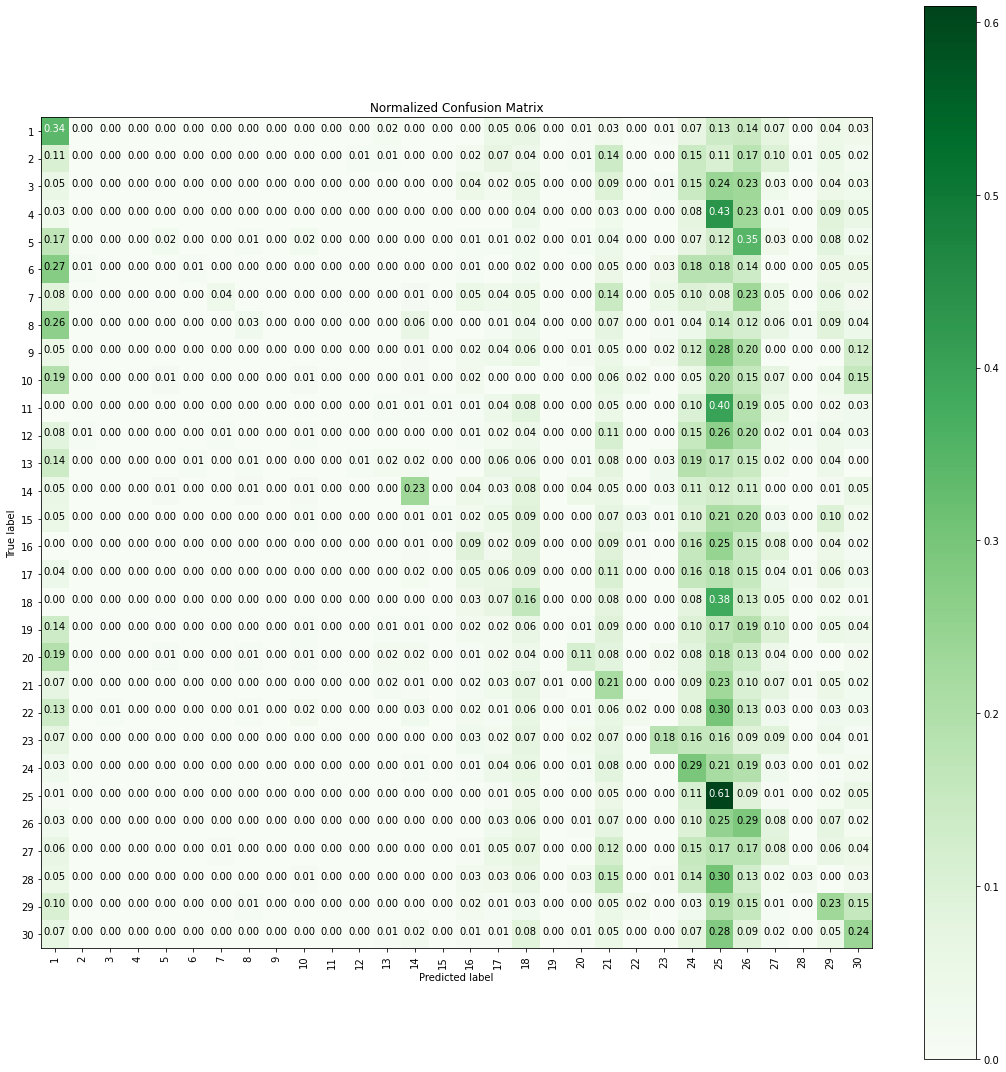


 F1 Score:0.08699261248927928


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.11073392686198176
--------
epsilon:  2.2
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:06:45.246710

Predicting test data
==> testing time:- 0:00:00.261206

==> Accuracy:- 0.11847719067935675


 ********Confusion Matrix********

 [[23  1  0  2  0  0  2  3  0  1  0  0  4  1  2  0  6 14  0  3 11  1  5  5
   8 10  7  0  6  5]
 [ 3  4  1  0  1  0  0  0  0  0  1  2  4  4  3  3  5  6  1  0 19  0  0  7
   8 14  6  0  8  3]
 [ 4  2  0  0  2  0  0  0  0  0  3  0  1  1  2  2  3  8  1  0 12  3  1 10
  11 14  7  0  7  1]
 [ 0  1  1  1  2  1  0  0  0  1  1  3  2  0  1  2  4  8  1  1  6 

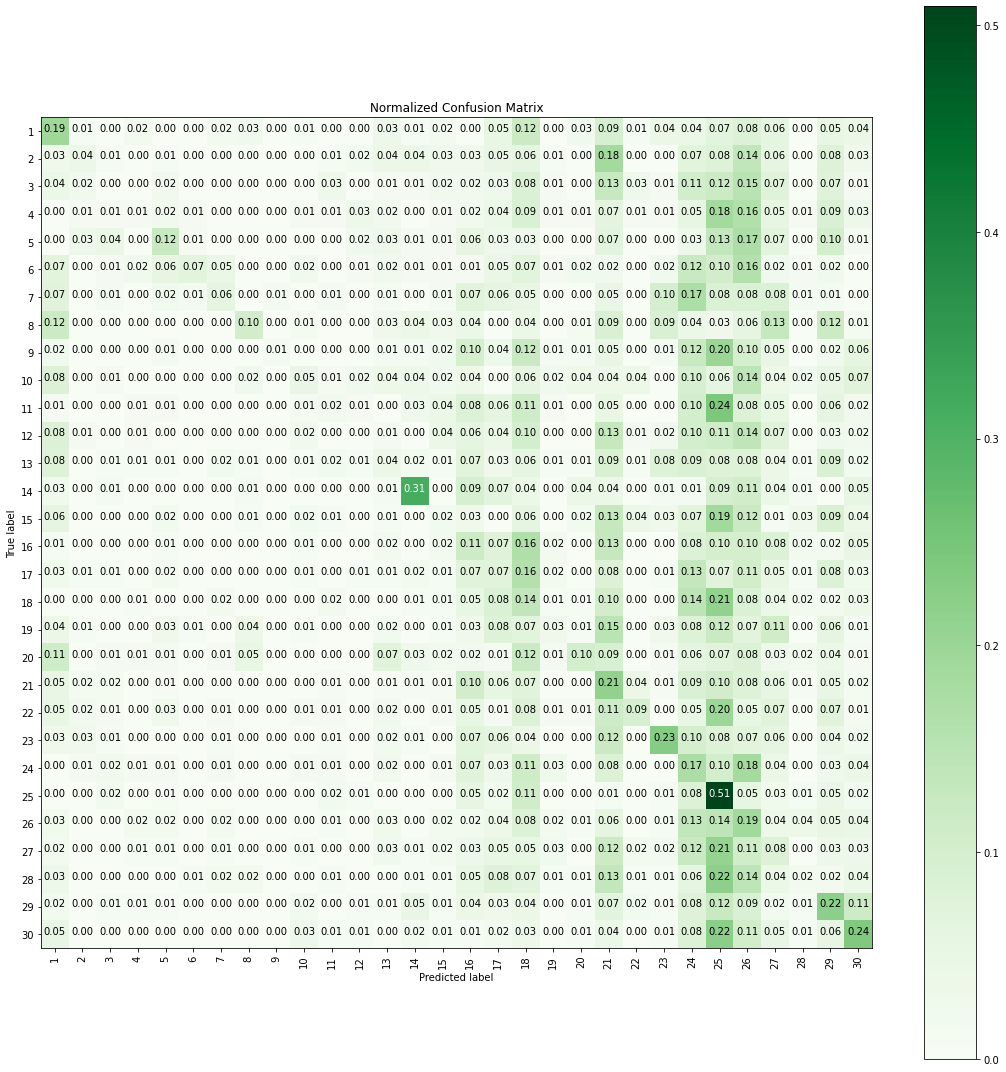


 F1 Score:0.1071911153130523


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.12334390749415898


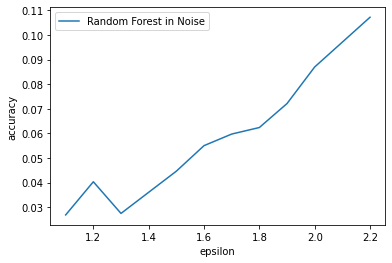

[0.02688222467057043, 0.0403490593191627, 0.027492357511122088, 0.04465487234205738, 0.0550249744119981, 0.059729753518934454, 0.06238958422937489, 0.07212880940718, 0.08699261248927928, 0.1071911153130523]


In [129]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

acc_array_random_uid = list()
f1_array_random_uid = list()

epsilons = [1.1, 1.2, 1.3, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'user_Id')

  # for feature in f_add_weighted_noise:
  #   print(X_train[feature])
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   print(X_train[feature])

  for col in X_train:
      # default sensitivity = 1.0
    # if col not in f_add_weighted_noise:
    #   # print("------epsilon--------")
    #   X_train[col] = X_train[col].apply(lambda x: x + np.random.normal(0, 1.0/epsilon))
    #   X_test[col] = X_test[col].apply(lambda x: x + np.random.normal(0, 1.0/epsilon))
    # else :
    #   # print("------weighted_epsilon--------")
    #   X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
    #   X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
    
    if col in f_add_weighted_noise:
      # print("------epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.normal(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.normal(0, 1.0/weighted_epsilon))

    # print("------weighted_epsilon--------")
    X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))

  
  params = {'n_estimators': np.arange(150,181,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid,  X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_uid)
  f1_array_random_uid.append(f1)
  acc_array_random_uid.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], f1_array_random_uid[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print(f1_array_random_uid)

## HAR

--------
epsilon:  1.1
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:06:48.926616

Predicting test data
==> testing time:- 0:00:00.179059

==> Accuracy:- 0.6137184115523465


 ********Confusion Matrix********

 [[405  61  70   0   2   3]
 [226 183  63   2  14   4]
 [139  40 249   0   0   0]
 [  0   2   0  98 322  84]
 [  0   0   0  89 411  33]
 [  0   0   0   9  14 524]]


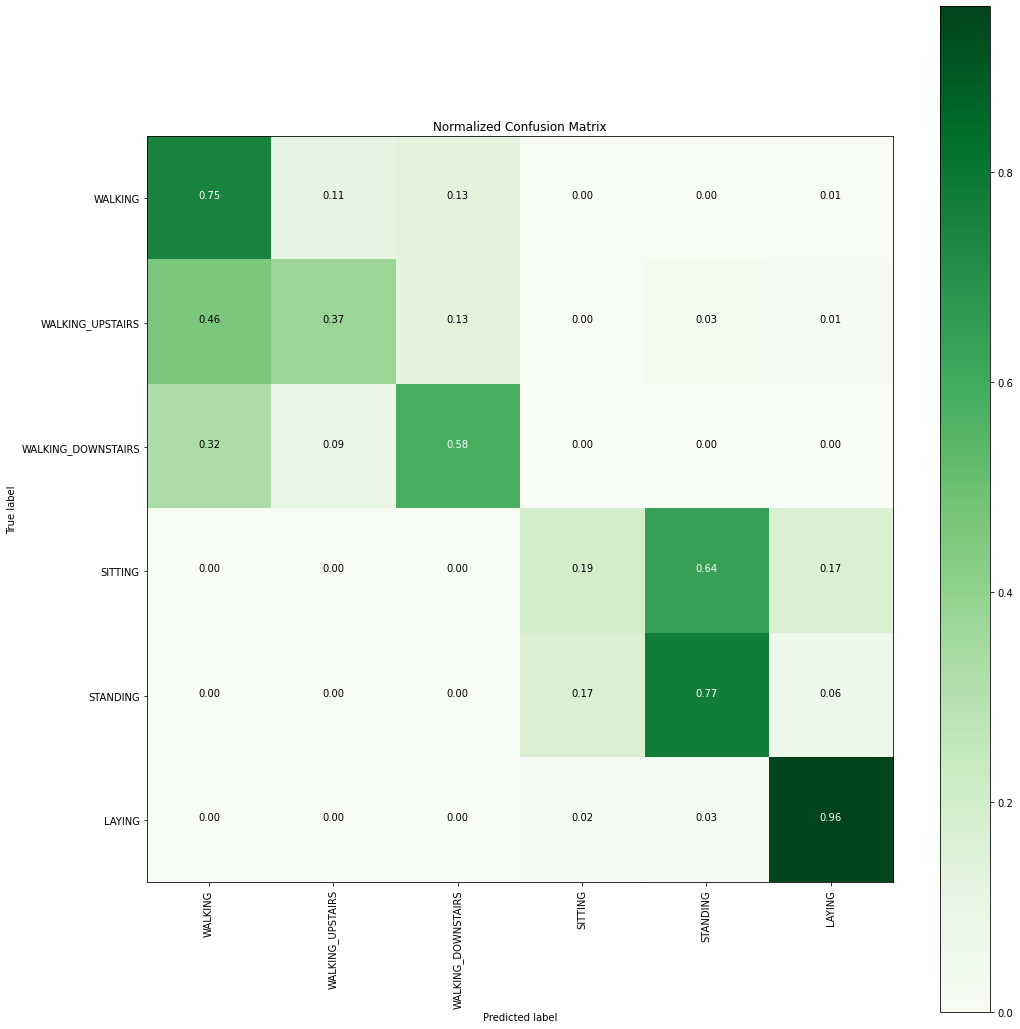


 F1 Score:0.5821261001547474


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6304575011460056
--------
epsilon:  1.2
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:07:43.040474

Predicting test data
==> testing time:- 0:00:00.316721

==> Accuracy:- 0.6337381030521825


 ********Confusion Matrix********

 [[426  55  56   1   2   1]
 [249 163  65   1  12   2]
 [136  34 256   1   1   0]
 [  0   0   0  98 343  65]
 [  0   0   0  56 456  21]
 [  0   0   0   6   9 532]]


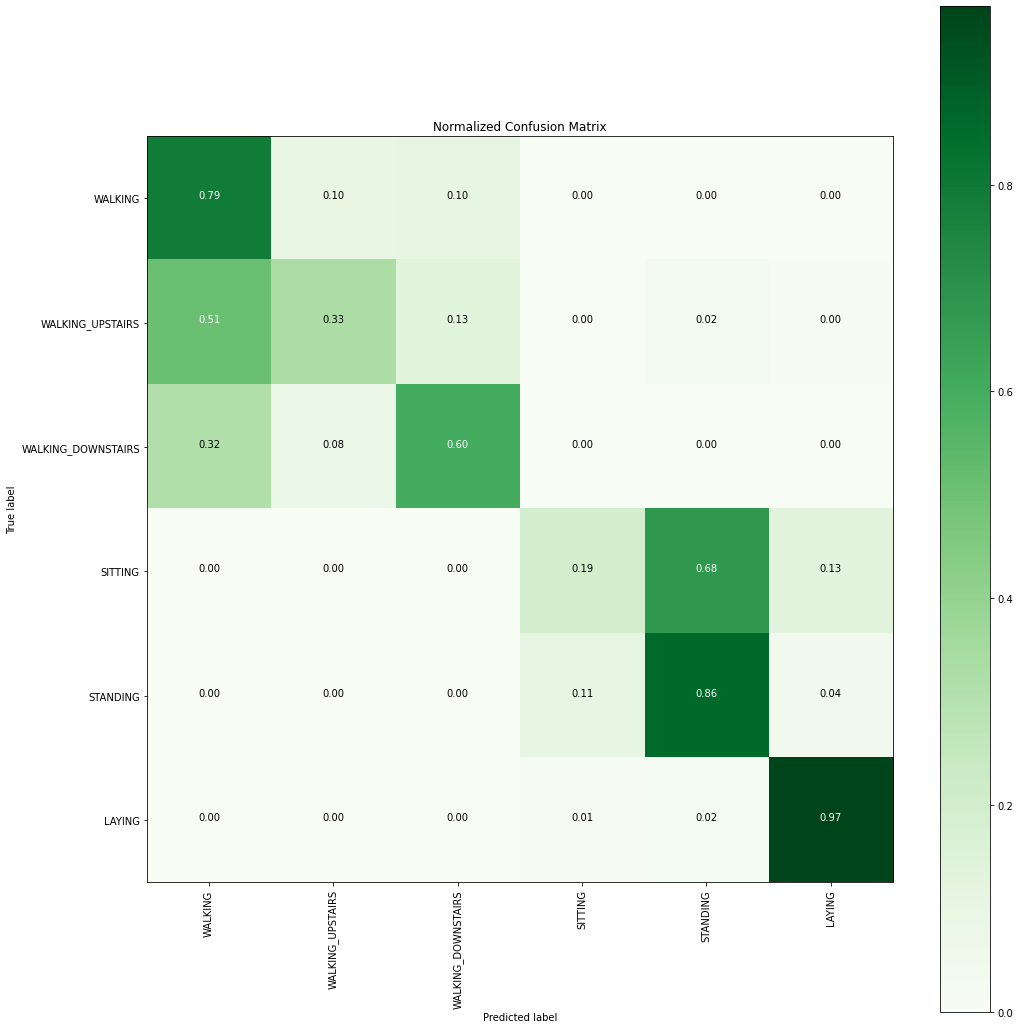


 F1 Score:0.5968123778756448


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.659878569105776
--------
epsilon:  1.3
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:07:50.126974

Predicting test data
==> testing time:- 0:00:00.380220

==> Accuracy:- 0.6606498194945848


 ********Confusion Matrix********

 [[449  35  50   0   6   1]
 [233 206  41   2  10   0]
 [123  34 270   0   1   0]
 [  0   0   0 105 349  52]
 [  0   0   0  62 454  17]
 [  0   0   0  11   7 529]]


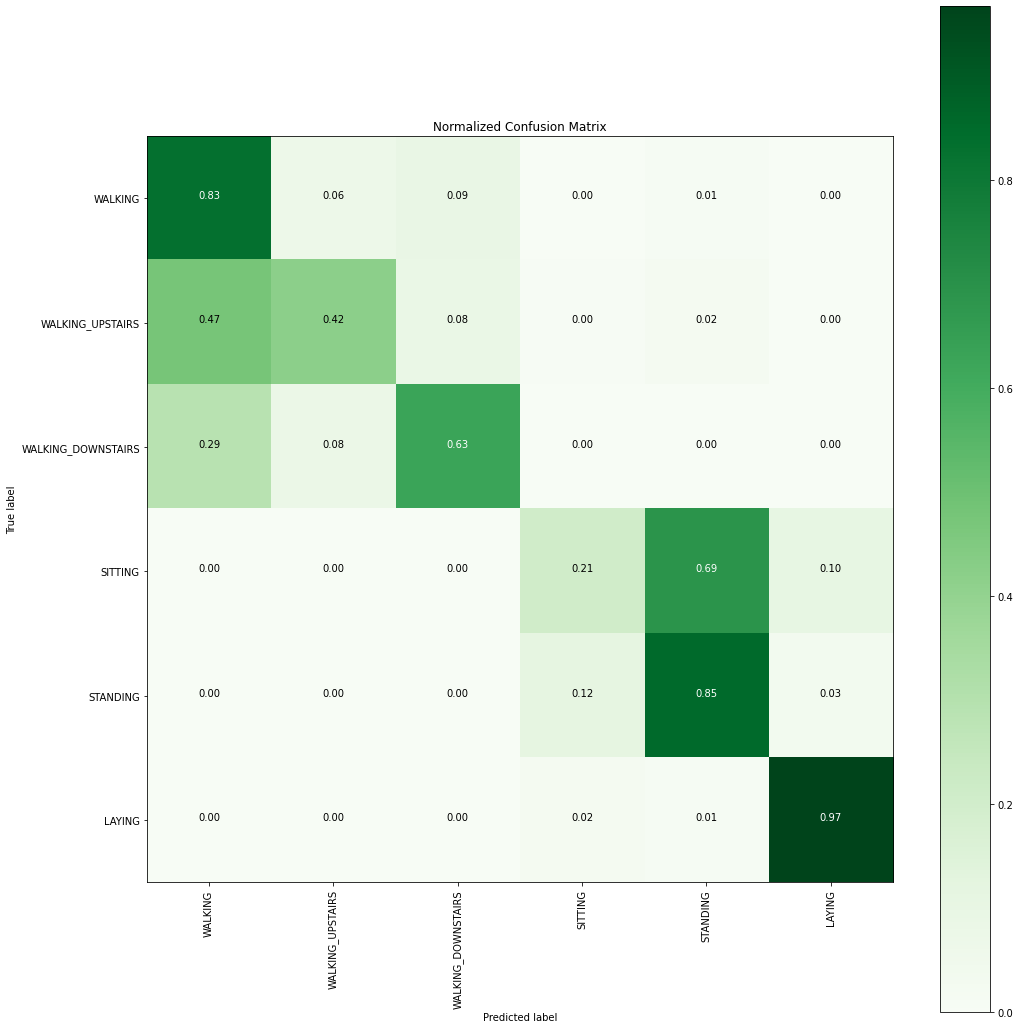


 F1 Score:0.6309518403898626


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6653716911126115
--------
epsilon:  1.5
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:06:17.570285

Predicting test data
==> testing time:- 0:00:00.113934

==> Accuracy:- 0.6993764358385297


 ********Confusion Matrix********

 [[465  32  40   1   2   1]
 [228 214  40   1   9   0]
 [ 95  37 295   0   0   1]
 [  0   0   0 133 335  38]
 [  0   0   0  43 481   9]
 [  0   0   0   4   0 543]]


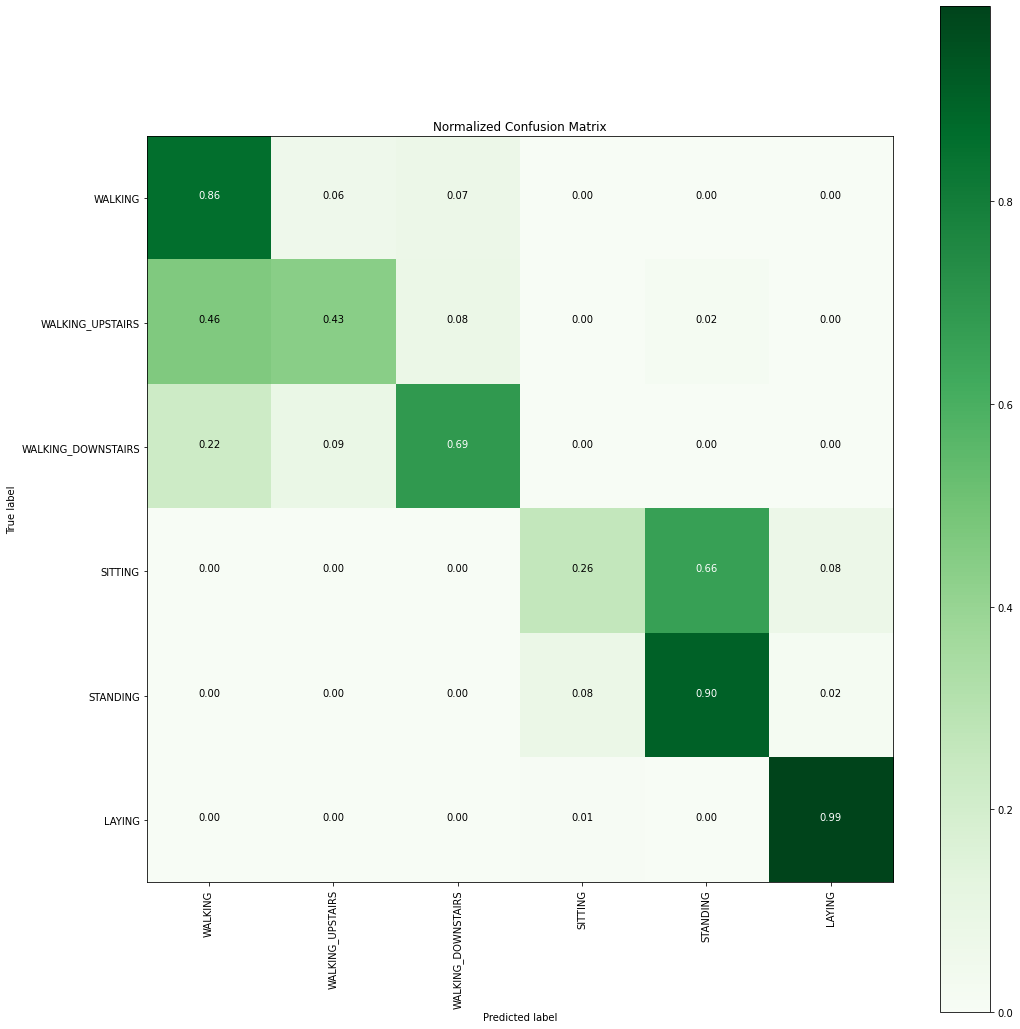


 F1 Score:0.6723709734547327


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6996425507017734
--------
epsilon:  1.6
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:06:05.282668

Predicting test data
==> testing time:- 0:00:00.121588

==> Accuracy:- 0.7075812274368231


 ********Confusion Matrix********

 [[473  21  44   0   2   1]
 [198 238  51   1   2   2]
 [100  28 300   0   0   0]
 [  0   0   0  91 365  50]
 [  0   0   0  17 511   5]
 [  0   0   0   0   4 543]]


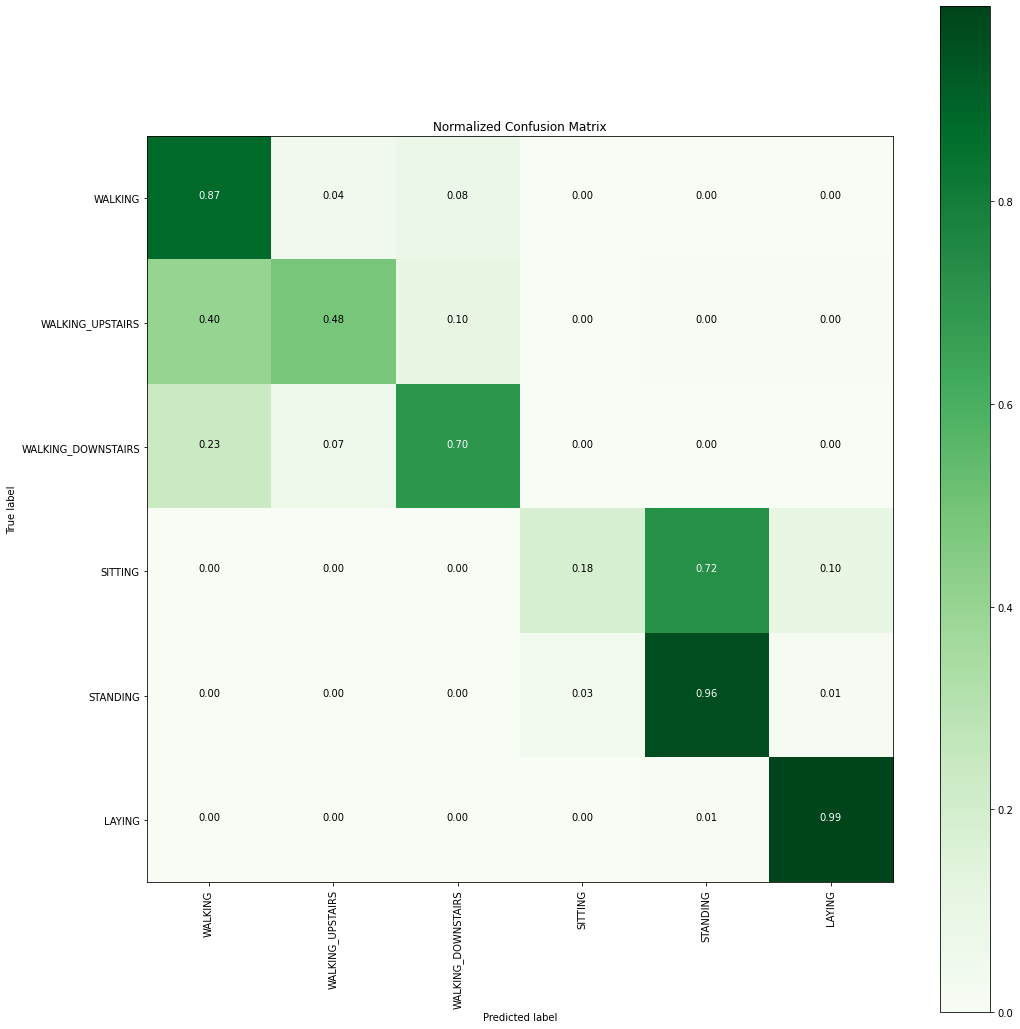


 F1 Score:0.6707144214299587


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7175865838321125
--------
epsilon:  1.7
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:06:45.039457

Predicting test data
==> testing time:- 0:00:00.121574

==> Accuracy:- 0.7295700689202494


 ********Confusion Matrix********

 [[460  36  41   0   4   0]
 [169 273  46   0   4   0]
 [105  38 285   0   0   0]
 [  0   0   0 179 290  37]
 [  0   0   0  47 482   4]
 [  0   0   0   3   0 544]]


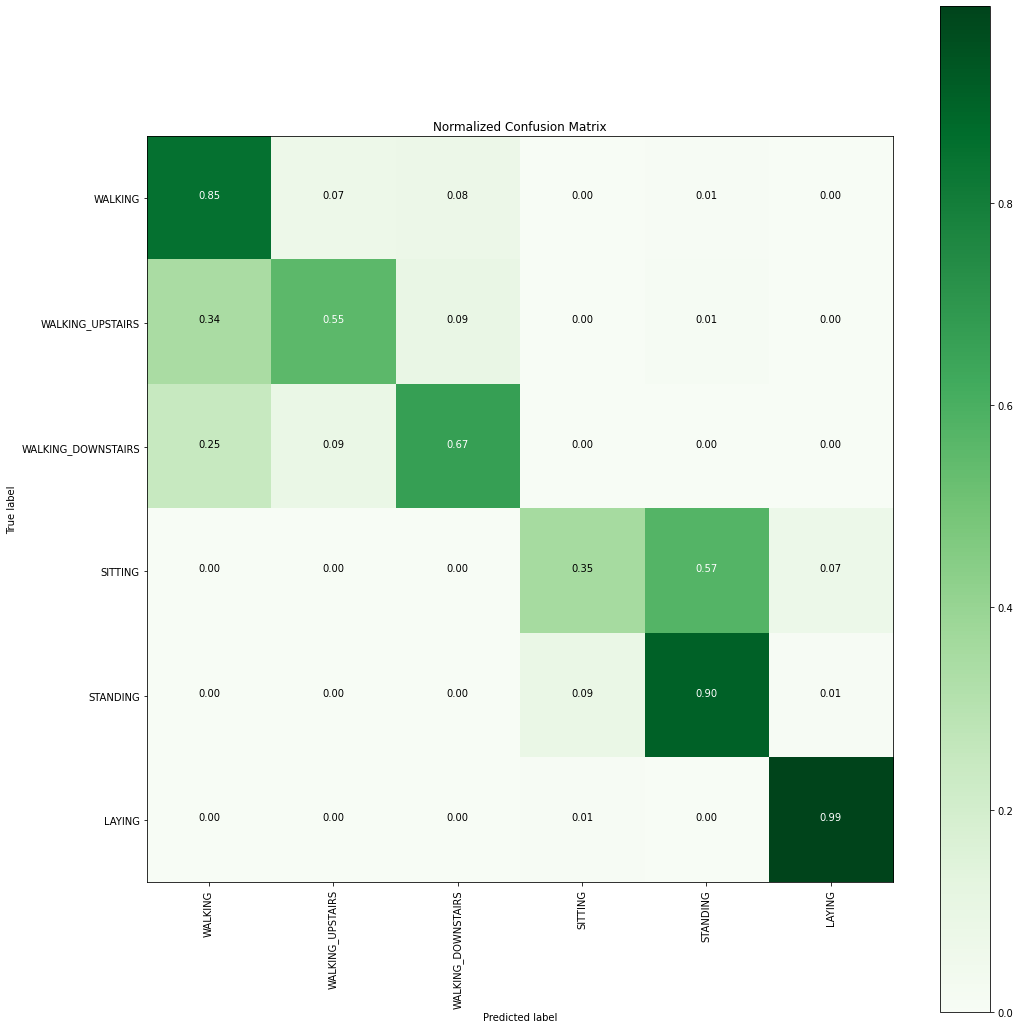


 F1 Score:0.7112075713047928


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7394126704479413
--------
epsilon:  1.8
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:06:41.689404

Predicting test data
==> testing time:- 0:00:00.167100

==> Accuracy:- 0.733836560551362


 ********Confusion Matrix********

 [[469  32  38   0   1   1]
 [180 266  44   1   1   0]
 [ 81  50 296   0   1   0]
 [  0   0   0 190 273  43]
 [  0   0   0  60 471   2]
 [  0   0   0   2   1 544]]


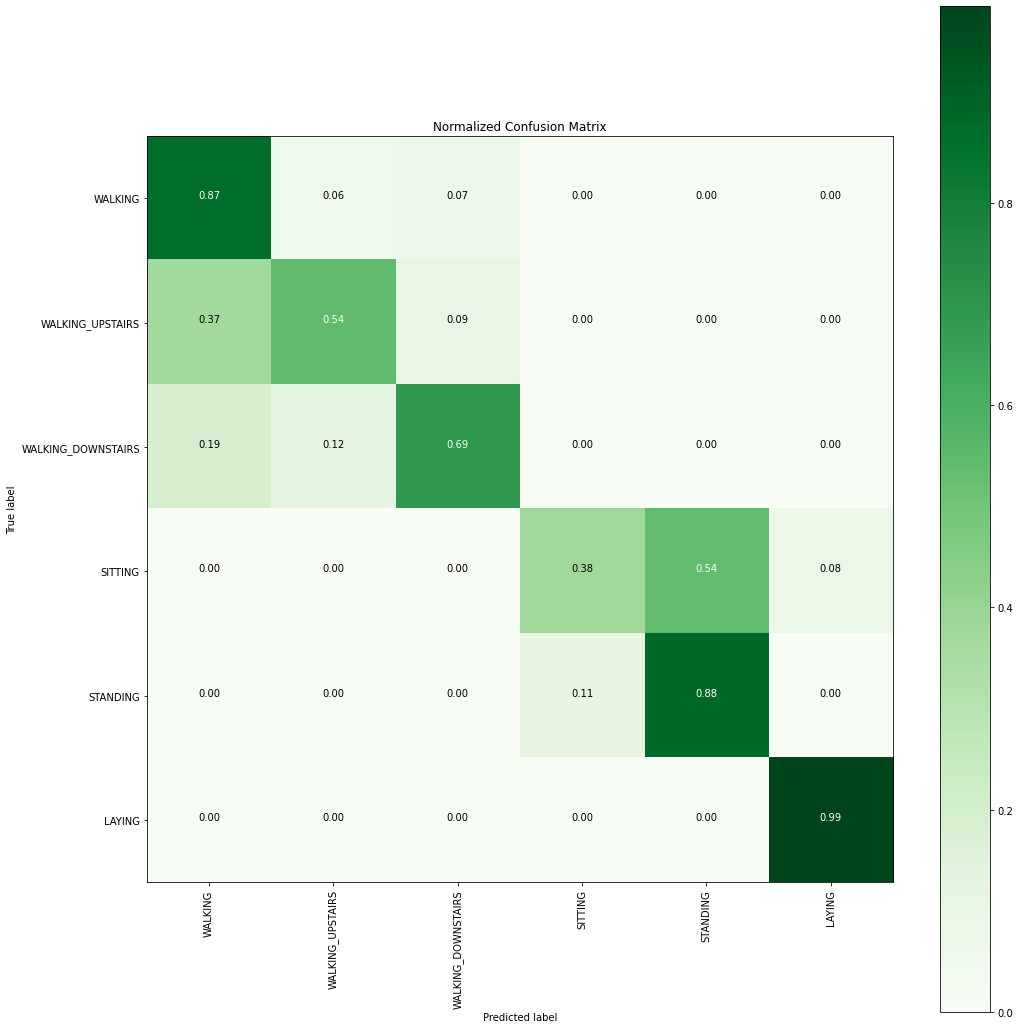


 F1 Score:0.7164586858175791


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7403822369770003
--------
epsilon:  1.9
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:06:44.364708

Predicting test data
==> testing time:- 0:00:00.153064

==> Accuracy:- 0.744995077125041


 ********Confusion Matrix********

 [[463  45  32   0   1   0]
 [146 299  41   1   5   0]
 [ 74  50 304   0   0   0]
 [  0   0   0 178 292  36]
 [  0   0   0  51 479   3]
 [  0   0   0   0   0 547]]


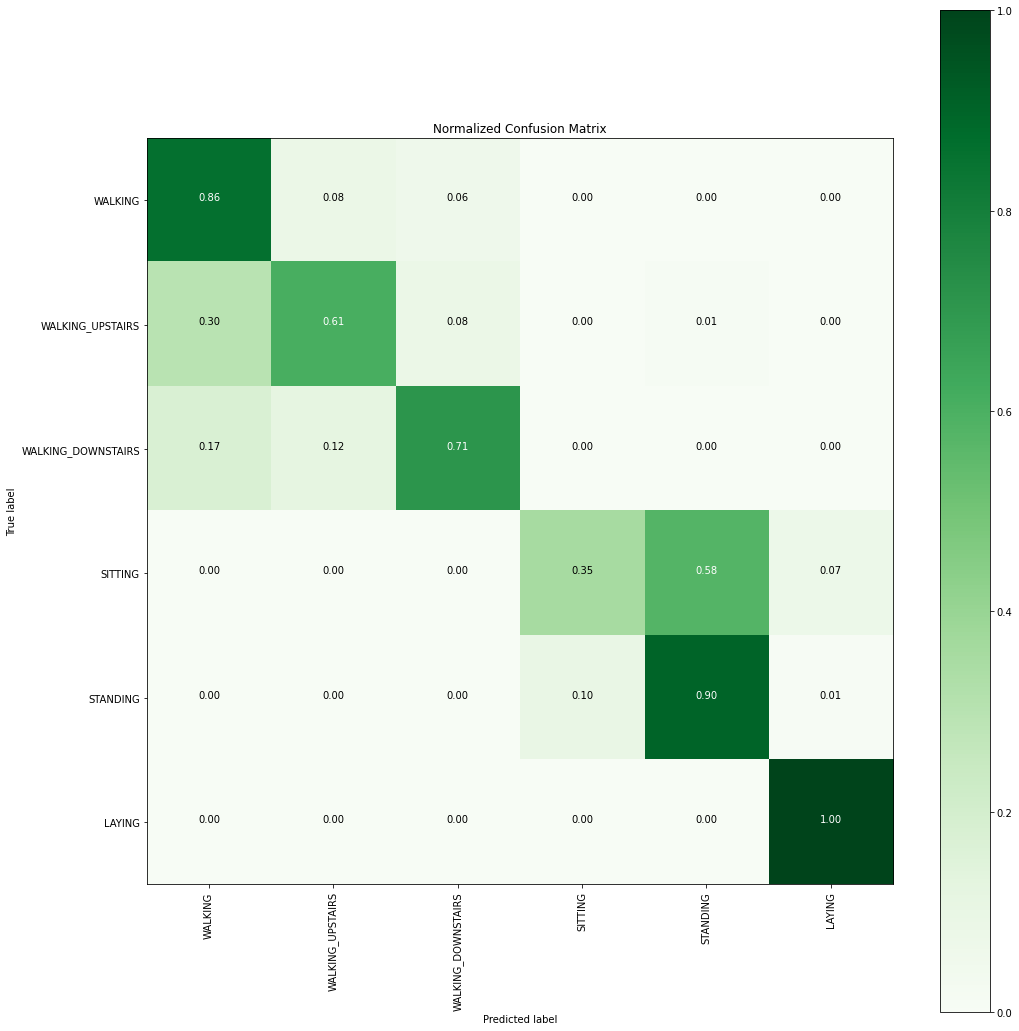


 F1 Score:0.7278884151193644


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7552548442411744
--------
epsilon:  2.0
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:06:24.027779

Predicting test data
==> testing time:- 0:00:00.110425

==> Accuracy:- 0.7591073186741056


 ********Confusion Matrix********

 [[473  34  34   0   0   0]
 [133 304  51   0   4   0]
 [ 72  46 310   0   0   0]
 [  0   0   0 218 261  27]
 [  0   0   0  64 465   4]
 [  0   0   0   1   3 543]]


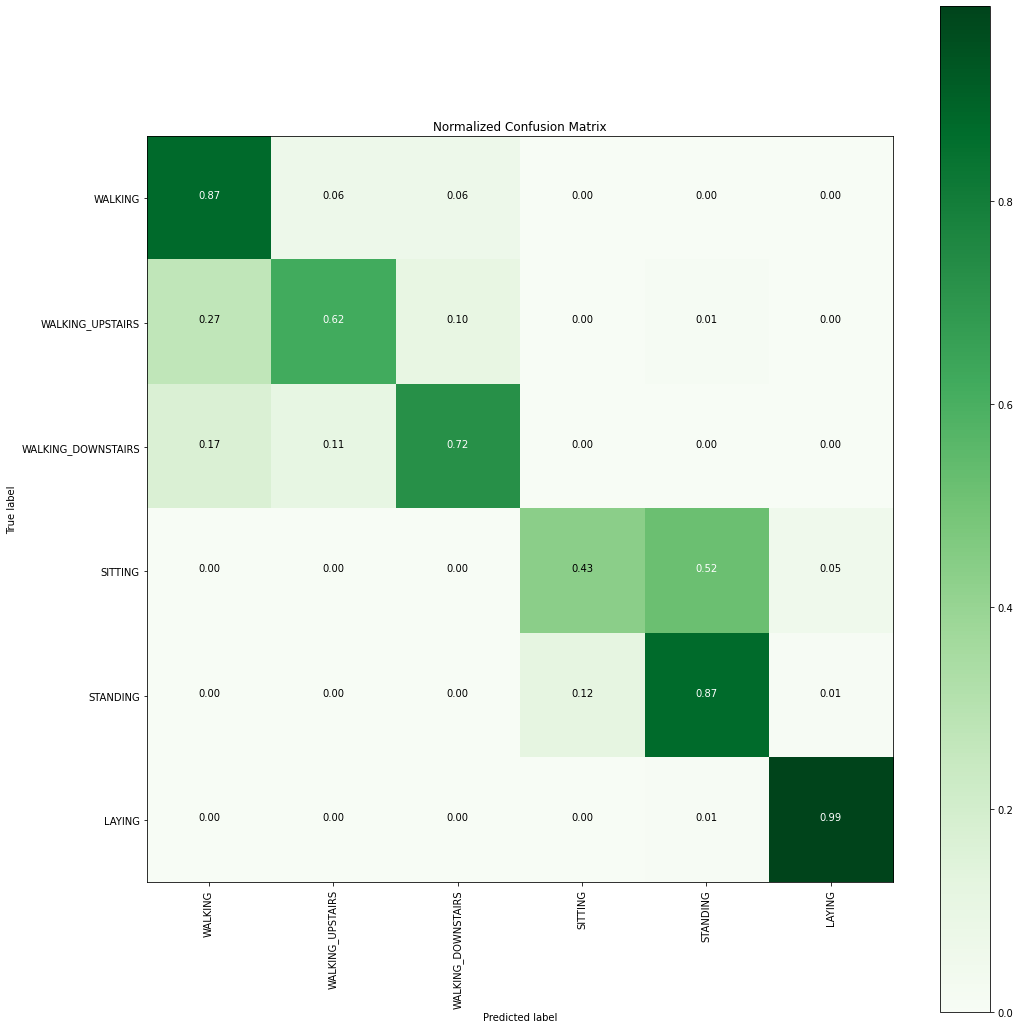


 F1 Score:0.7465707598182937


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7693187828701207
--------
epsilon:  2.2
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:06:29.066095

Predicting test data
==> testing time:- 0:00:00.150245

==> Accuracy:- 0.7630456186412865


 ********Confusion Matrix********

 [[458  45  38   0   0   0]
 [130 325  36   0   1   0]
 [ 68  51 309   0   0   0]
 [  0   0   0 213 265  28]
 [  0   0   0  58 474   1]
 [  0   0   0   1   0 546]]


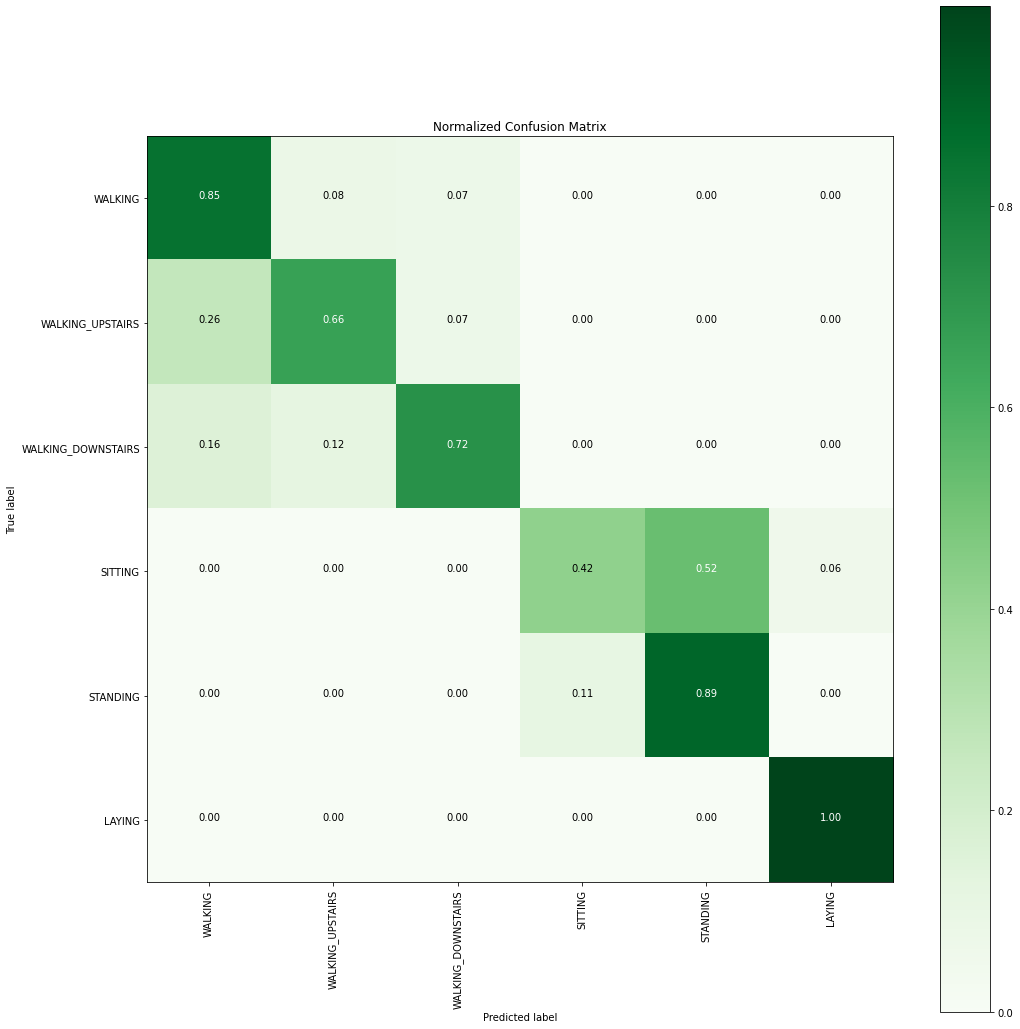


 F1 Score:0.7507874575890243


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7804727159224922


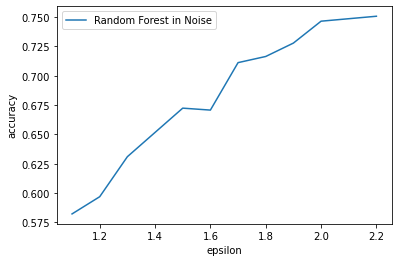

[0.5821261001547474, 0.5968123778756448, 0.6309518403898626, 0.6723709734547327, 0.6707144214299587, 0.7112075713047928, 0.7164586858175791, 0.7278884151193644, 0.7465707598182937, 0.7507874575890243]


In [130]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

acc_array_random_har = list()
f1_array_random_har = list()


epsilons = [1.1, 1.2, 1.3, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'activity_Id')

  # for feature in f_add_weighted_noise:
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  for col in X_train:
      # default sensitivity = 1.0
    # if col not in f_add_weighted_noise:
    #   # print("------epsilon--------")
    #   X_train[col] = X_train[col].apply(lambda x: x + np.random.normal(0, 1.0/epsilon))
    #   X_test[col] = X_test[col].apply(lambda x: x + np.random.normal(0, 1.0/epsilon))
    # else :
    #   # print("------weighted_epsilon--------")
    #   X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
    #   X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
    
    if col in f_add_weighted_noise:
          # print("------epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.normal(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.normal(0, 1.0/weighted_epsilon))

    # print("------weighted_epsilon--------")
    X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))

    
  params = {'n_estimators': np.arange(150,201,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_act)
  f1_array_random_har.append(f1)
  acc_array_random_har.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], f1_array_random_har[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print(f1_array_random_har)

In [131]:
# [1.2, 1.3, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2]
# epsilons = [1.1, 1.2, 1.3, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2]
print(f1_array_random_har)
print(f1_array_random_uid)
print(acc_array_random_har)
print(acc_array_random_uid)

[0.5821261001547474, 0.5968123778756448, 0.6309518403898626, 0.6723709734547327, 0.6707144214299587, 0.7112075713047928, 0.7164586858175791, 0.7278884151193644, 0.7465707598182937, 0.7507874575890243]
[0.02688222467057043, 0.0403490593191627, 0.027492357511122088, 0.04465487234205738, 0.0550249744119981, 0.059729753518934454, 0.06238958422937489, 0.07212880940718, 0.08699261248927928, 0.1071911153130523]
[0.6137184115523465, 0.6337381030521825, 0.6606498194945848, 0.6993764358385297, 0.7075812274368231, 0.7295700689202494, 0.733836560551362, 0.744995077125041, 0.7591073186741056, 0.7630456186412865]
[0.05480800787659994, 0.05612077453232688, 0.05382343288480473, 0.07154578273711848, 0.08204791598293404, 0.09189366590088612, 0.0935346242205448, 0.09025270758122744, 0.11782080735149328, 0.11847719067935675]


In [132]:
print(weighted_epsilon)
print(n)
print(epsilons)

0.001
119
[1.1, 1.2, 1.3, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2]


In [133]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()') 

In [134]:
beep()

ModuleNotFoundError: No module named 'google.colab'